# Merge bottle and satellite data extracted at observation locations
Created by Ivan Lima on Mon Aug  2 2021 17:04:08 -0400

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Mon Aug  2 17:19:58 2021


In [2]:
sns.set_theme(context='paper', style='whitegrid', palette='tab10', rc={'figure.dpi':100})
pd.options.display.max_columns = 50

## Read satellite & bottle data 

In [3]:
df_sat = pd.read_csv('data/Bottle_metadata_satellite.csv', index_col=0)
df_sat['Date'] = pd.to_datetime(df_sat[['Year','Month','Day']])

df_bottle = pd.read_csv('work/MachineLearningDataset.csv', index_col=0)
df_bottle['Date'] = pd.to_datetime(df_bottle[['Year','Month','Day']])

## Do inner join 

In [4]:
sat_cols = ['Date', 'Latitude', 'Longitude', 'CASTNO_Database', 'ADT', 'UGOS', 'VGOS',
            'SLA', 'UGOSA', 'VGOSA', 'SST', 'SST_hires', 'Chl', 'KD490']

bot_cols = ['X.x', 'X.y', 'DOI', 'EXPOCODE', 'Accession', 'Cruise_ID', 'Date', 'Year', 'Month','Day', 'Time_UTC',
            'Latitude', 'Longitude', 'Depth_bottom', 'Depth','CASTNO_Original', 'CASTNO_Database', 'Pressure',
            'Salinity','Temperature', 'Oxygen', 'DIC', 'DIC_FLAG', 'TA', 'TA_FLAG', 'pH','pH_FLAG', 'pCO2_yearave',
            'pCO2_monthave', 'bottom_depth', 'OmegaA', 'OmegaC', 'pCO2insitu', 'pHT']

df_merged = pd.merge(df_bottle[bot_cols], df_sat[sat_cols], on=['Date','Latitude','Longitude'],
                     how='inner', suffixes=['_bot', '_sat'])

print('Original data: {} rows'.format(len(df_bottle)))
print('New merged data: {} rows'.format(len(df_merged)))
print('Difference: {} rows'.format(len(df_merged)-len(df_bottle)))

Original data: 2748 rows
New merged data: 3040 rows
Difference: 292 rows


In [5]:
# bcols = [c for c in df_merged.columns if c.endswith('_bot')]
# scols = [c for c in df_merged.columns if c.endswith('_sat')]
# ccols = sorted(bcols + scols)
# df_merged[ccols].tail(10)

## Check if records match for merged variables 

In [6]:
def check(vname):
    vname_bot, vname_sat = vname+'_bot', vname+'_sat'
    df_work = df_merged[[vname_bot, vname_sat]].dropna()
    if len(df_work) == (df_work[vname_bot]==df_work[vname_sat]).sum():
        print('{}: OK'.format(vname))
    else:
        n = len(df_work) - (df_work[vname_bot]==df_work[vname_sat]).sum()
        print('{}: {} records do not match'.format(vname, n))

varcols = [c.rstrip('_bot') for c in df_merged.columns if c.endswith('_bot')]
for vname in varcols:
    check(vname)

CASTNO_Database: 292 records do not match


**Note:** The number of extra rows in the new merged data set is the same as the number of records for which CASTNO_Database does not match in the bottle and merged data sets. So Louise probably removed the records for which CASTNO_Database does not match. So we only use records where CASTNO_Database matches.

In [7]:
df_bot_sat = df_merged[df_merged['CASTNO_Database_bot']==df_merged['CASTNO_Database_sat']]

## Plot satelitte data for original and new dataset

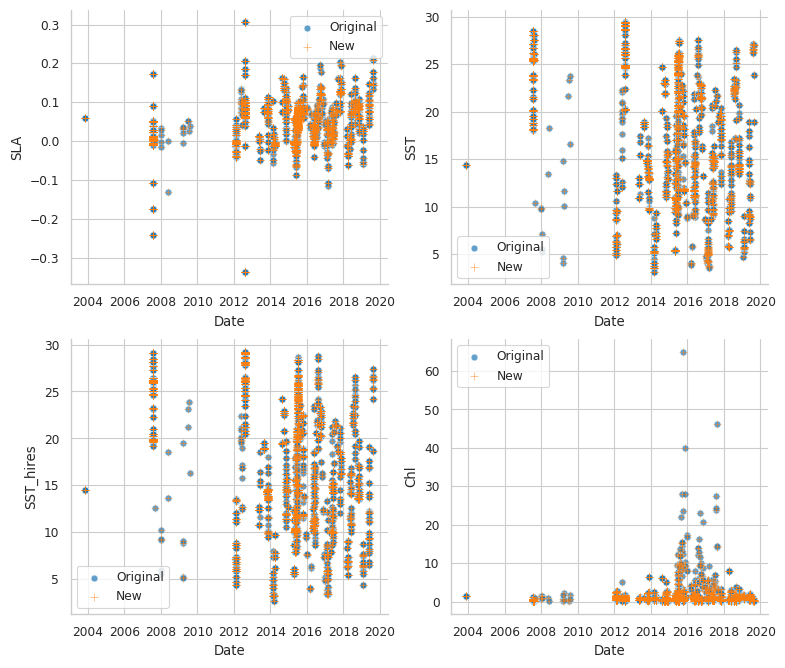

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))
for ax, vname in zip(axs.ravel(),['SLA','SST','SST_hires','Chl']):
    _ = sns.scatterplot(x='Date', y=vname, data=df_bottle, ax=ax, alpha=0.7, label='Original')
    _ = sns.scatterplot(x='Date', y=vname, data=df_bot_sat, ax=ax, alpha=0.7, marker='+', s=30, edgecolor=None, label='New')

sns.despine(fig)

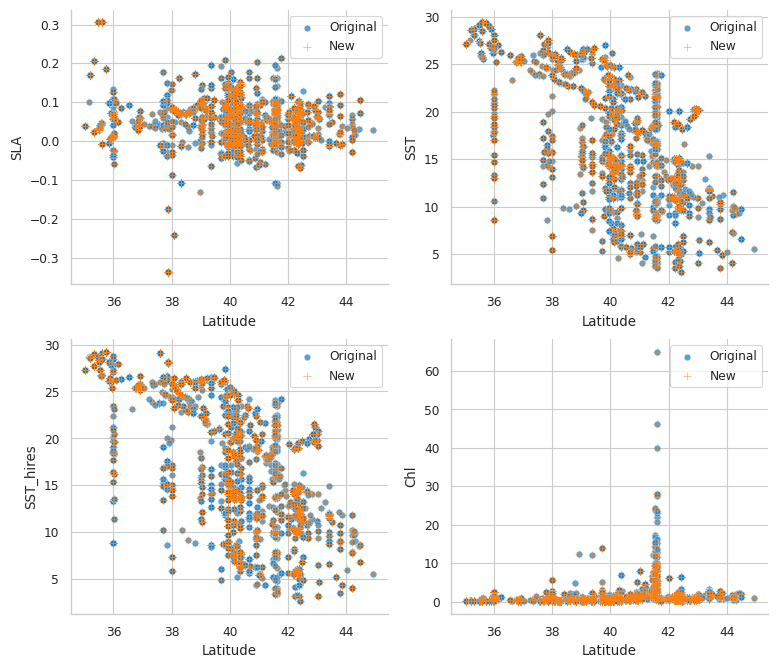

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))
for ax, vname in zip(axs.ravel(),['SLA','SST','SST_hires','Chl']):
    _ = sns.scatterplot(x='Latitude', y=vname, data=df_bottle, ax=ax, alpha=0.7, label='Original')
    _ = sns.scatterplot(x='Latitude', y=vname, data=df_bot_sat, ax=ax, alpha=0.7, marker='+', s=30, edgecolor=None, label='New')

sns.despine(fig)

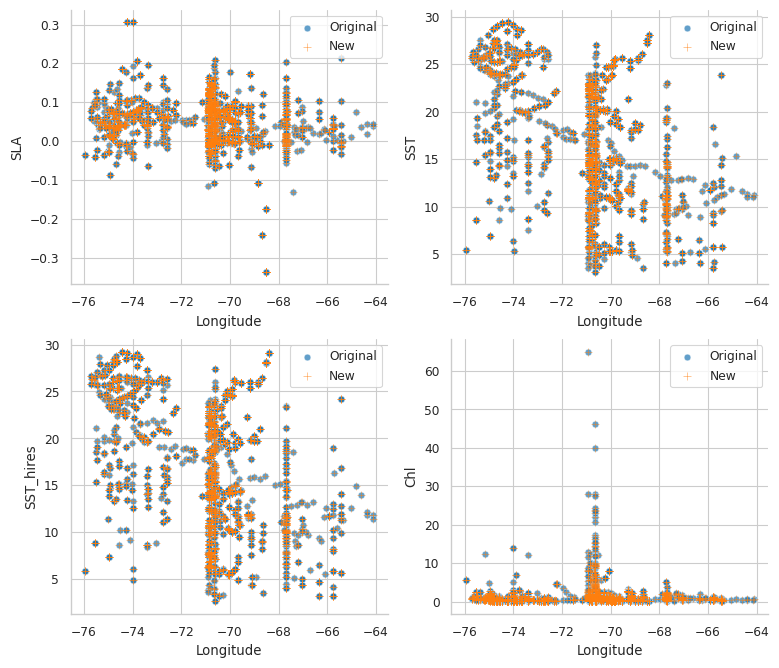

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(9,8))
for ax, vname in zip(axs.ravel(),['SLA','SST','SST_hires','Chl']):
    _ = sns.scatterplot(x='Longitude', y=vname, data=df_bottle, ax=ax, alpha=0.7, label='Original')
    _ = sns.scatterplot(x='Longitude', y=vname, data=df_bot_sat, ax=ax, alpha=0.7, marker='+', s=30, edgecolor=None, label='New')

sns.despine(fig)

## Compare original and new data sets 

The two data sets are the same except for differences in precision for the satellite variables.

In [11]:
df_new = df_bot_sat.drop(labels=['CASTNO_Database_bot','CASTNO_Database_sat','KD490'],axis=1)
df_new = df_new.sort_values(by=['Date','Latitude','Longitude']).reset_index(drop=True)

df_old = df_bottle[df_new.columns].sort_values(by=['Date','Latitude','Longitude']).reset_index(drop=True)

# Print difference between each variable in the two data sets
def check_diff(vname):
    diff = df_new[vname] - df_old[vname]
    print('{}: {}, {}'.format(vname, diff.min(), diff.max()))

for vname in ['X.x', 'X.y', 'Latitude', 'Longitude', 'Depth_bottom', 'Depth', 'Pressure', 'Salinity', 'Temperature',
              'Oxygen', 'DIC', 'DIC_FLAG', 'TA', 'TA_FLAG', 'pH', 'pH_FLAG', 'pCO2_yearave', 'pCO2_monthave', 'bottom_depth',
              'OmegaA', 'OmegaC', 'pCO2insitu', 'pHT', 'ADT', 'UGOS', 'VGOS', 'SLA', 'UGOSA', 'VGOSA', 'SST', 'SST_hires', 'Chl']:
    check_diff(vname)

X.x: 0, 0
X.y: 0, 0
Latitude: 0.0, 0.0
Longitude: 0.0, 0.0
Depth_bottom: 0.0, 0.0
Depth: 0.0, 0.0
Pressure: 0.0, 0.0
Salinity: 0.0, 0.0
Temperature: 0.0, 0.0
Oxygen: 0.0, 0.0
DIC: 0.0, 0.0
DIC_FLAG: 0.0, 0.0
TA: 0.0, 0.0
TA_FLAG: 0.0, 0.0
pH: 0.0, 0.0
pH_FLAG: 0.0, 0.0
pCO2_yearave: 0.0, 0.0
pCO2_monthave: 0.0, 0.0
bottom_depth: 0, 0
OmegaA: 0.0, 0.0
OmegaC: 0.0, 0.0
pCO2insitu: 0.0, 0.0
pHT: 0.0, 0.0
ADT: -4.996003610813204e-16, 5.134781488891349e-16
UGOS: -3.552713678800501e-15, 5.134781488891349e-16
VGOS: -4.996003610813204e-16, 1.1102230246251565e-15
SLA: -4.996003610813204e-16, 4.996003610813204e-16
UGOSA: -4.996003610813204e-16, 2.4424906541753444e-15
VGOSA: -4.996003610813204e-16, 4.996003610813204e-16
SST: -5.3290705182007514e-14, 4.973799150320701e-14
SST_hires: -4.973799150320701e-14, 4.973799150320701e-14
Chl: -4.618527782440651e-14, 4.796163466380676e-14


**Note:** The test below fails because of differences in precision between the two data sets.

In [12]:
df_new.equals(df_old)

False

## Save merged data set to CSV file 

In [13]:
df_bot_sat_final = df_bot_sat.drop('CASTNO_Database_sat', axis=1).rename(columns={'CASTNO_Database_sat':'CASTNO_Database'})
df_bot_sat_final.to_csv('data/bottle_satellite_data.csv')